# K-Nearest-Neighbours Classification

The aim is to perform knn clustering. However, to compute the _distance_ between a point and its neighbours, we will use a prepared distance matrix.

This method will be _supervised_. 

The algorithm differs from the usual Knn algorithm, not least because of the distance matrix inputted (instead of Euclidean distances being used) but because in the case where no mode can be found, the class of the point with the shortest distance is chosen instead.

### Imports

In [1]:
import fdasrsf
from statistics import mode
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt 
from numpy import tile, eye, arccos, zeros, sin, arange, linspace, empty
from copy import deepcopy
import fdasrsf.geodesic as gd
import os
from tqdm import notebook as tqdm
import re
import seaborn as sns; sns.set()
from sklearn.metrics import confusion_matrix

### Data

In [2]:
# Index of all pots, including classes and train/test label.
table = pd.read_csv("all_sample_IDs_716.csv")

# Index of training sample
train = list(table[table["AlgType"]=="train"].index)

# Index of test sample
test = list(table[table["AlgType"]=="test"].index)

In [3]:
# Distance matrix for all vases.
all_dists = pd.read_csv("all_dists_n716.csv")
all_dists = all_dists.set_index('PotName')

In [4]:
train_names = list(table[table["AlgType"]=="train"]["Name"])
test_names = list(table[table["AlgType"]=="test"]["Name"])

### Dictionaries for Knn

In [5]:
# We'll make note of the class accuracy of the results in the following dictionary.
# Here, we assume that we will test various values for K, up to K=8.
class_stats = {}
for pot in test_names:
    potclass = list(table[table["Name"]==pot]["Genus"])[0]
    class_stats.update({potclass:{"total":0,"K1":0,"K3":0,"K4":0,"K5":0,"K6":0,"K7":0,"K8":0}})
for pot in test_names:
    potclass = list(table[table["Name"]==pot]["Genus"])[0]
    tot = int(class_stats[potclass]["total"])
    class_stats[potclass]["total"] = tot+1

In [6]:
# We'll make note of the subspecie accuracy of the results in the following dictionary.
# Here, we assume that we will test various values for K, up to K=8.
subclass_stats = {}
for pot in test_names:
    potclass = list(table[table["Name"]==pot]["Species"])[0]
    subclass_stats.update({str(potclass):{"total":0,"K1":0,"K3":0,"K4":0,"K5":0,"K6":0,"K7":0,"K8":0}})
for pot in test_names:
    potclass = list(table[table["Name"]==pot]["Species"])[0]
    tot = int(subclass_stats[str(potclass)]["total"])
    subclass_stats[str(potclass)]["total"] = tot+1

In [7]:
act = np.unique(list(table["Species"]))

class_names = {}
classes_unq = np.unique(act)
for species in classes_unq:
    potclass = list(table[table["Species"]==species]["Genus"])[0]
    class_names.update({str(species):{"Genus":potclass}})
    
subclass_names = {}
subclasses_unq = np.unique(act)
for species in subclasses_unq:
    potclass = list(table[table["Species"]==species]["Genus"])[0]
    name = potclass+"_"+str(species)
    subclass_names.update({str(species):{"subclass":name}})


### Knn Algorithm

In [20]:
K = 8

# This will be updated during the Knn algorithm to contain the list of all the pots and their predicted sample.
# To start with, it only contains the details from the training sample.
class_details = {}
for pot in train_names:
    class_details.update({pot:{"specie":list(table[table["Name"]==pot]["Species"])[0]}})

for testpot in tqdm.tqdm(test_names):
    dists = []
    for trainpot in train_names:
        d = all_dists[testpot][trainpot]
        dists.append(d)
    toprnk = np.argsort(dists)[:K]
    top_classes = []
    for ind in toprnk:
        top_classes.append(class_details[train_names[ind]]["specie"])
    try:
        potclass = mode(top_classes)
    except:
        potclass = top_classes[0]
        
    class_details.update({testpot:{"specie":potclass}})
    
    

### Knn Results

In [21]:
k1 = 0
k2 = 0
knn = "K"+str(K)
for pot in test_names:
    pred_sp = int(class_details[pot]["specie"])
    act_sp = int(list(table[table["Name"]==pot]["Species"])[0])
    pred_cl = list(table[table["Species"]==pred_sp]["Genus"])[0]
    act_cl = list(table[table["Name"]==pot]["Genus"])[0]
    if pred_sp == act_sp:
        k1 = k1+1
        p = int(subclass_stats[str(pred_sp)][knn])
        subclass_stats[str(pred_sp)][knn] = p+1
    if pred_cl == act_cl:
        p = int(class_stats[pred_cl][knn])
        class_stats[pred_cl][knn] = p+1
        k2 = k2+1
prct1 = np.round(100*(k1/len(test_names)),2)
prct2 = np.round(100*(k2/len(test_names)),2)

print([str(prct1)+"%",str(prct2)+"%"])

['95.34%', '95.76%']


### Confusion Matrix

In [22]:
act_subclasses = []
pred_subclasses = []
act_classes = []
pred_classes = []

for pot in test_names:
    pred_sp = int(class_details[pot]["specie"])
    act_sp = int(list(table[table["Name"]==pot]["Species"])[0])
    
    act_cl_name = class_names[str(act_sp)]["Genus"]
    pred_cl_name = class_names[str(pred_sp)]["Genus"]
    act_sp_name = subclass_names[str(act_sp)]["subclass"]
    pred_sp_name = subclass_names[str(pred_sp)]["subclass"]
    
    act_classes.append(act_cl_name)
    pred_classes.append(pred_cl_name)
    act_subclasses.append(act_sp_name)
    pred_subclasses.append(pred_sp_name)


In [23]:
subclass_unq = list(np.sort(np.unique(act_subclasses)))
class_unq = list(np.sort(np.unique(act_classes)))

In [24]:
CM = confusion_matrix(act_classes, pred_classes,labels=class_unq,normalize='true')
cm_df = pd.DataFrame(CM)
cm_df = cm_df.rename(index=dict(zip(list(cm_df.index),class_unq)))
cm_df.columns = class_unq


CM = confusion_matrix(act_subclasses, pred_subclasses,labels=subclass_unq,normalize='true')
cm_df_sc = pd.DataFrame(CM)
cm_df_sc = cm_df_sc.rename(index=dict(zip(list(cm_df_sc.index),subclass_unq)))
cm_df_sc.columns = subclass_unq

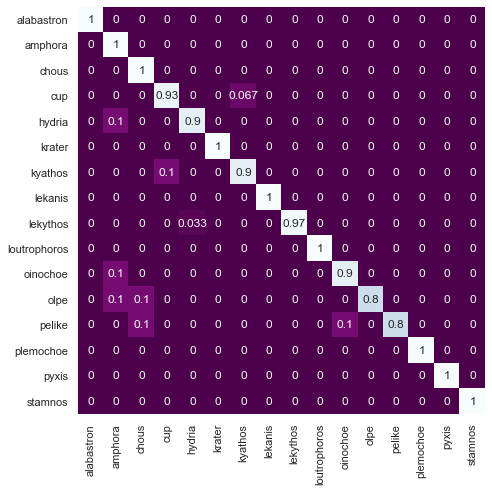

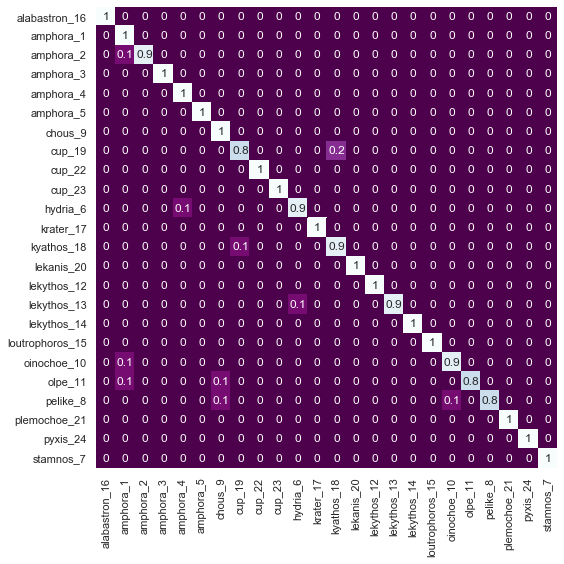

In [25]:
plt.figure(figsize=(7,7))
ax=plt.subplot(111)
plot = sns.heatmap(cm_df,ax=ax,cbar=False,annot=True,cmap="BuPu_r")
plt.tight_layout()
#plot.figure.savefig("class_confusion_mat_K"+str(K)+".png")

plt.figure(figsize=(8,8))
ax=plt.subplot(111)
plot = sns.heatmap(cm_df_sc,ax=ax,cbar=False,annot=True,cmap="BuPu_r")
plt.tight_layout()
#plot.figure.savefig("subclass_confusion_mat_K"+str(K)+".png")

### Specie Accuracy Bar Charts

In [26]:
df = pd.DataFrame(subclass_stats).T
df["K1%"] = np.round(100*df['K1']/df['total'],2)
df["K3%"] = np.round(100*df['K3']/df['total'],2)
df["K4%"] = np.round(100*df['K4']/df['total'],2)
df["K5%"] = np.round(100*df['K5']/df['total'],2)
df["K6%"] = np.round(100*df['K6']/df['total'],2)
df["K7%"] = np.round(100*df['K7']/df['total'],2)
df["K8%"] = np.round(100*df['K8']/df['total'],2)
df_prct = deepcopy(df)

In [27]:
subclasses = list(df_prct.index)
for n,potclass in enumerate(subclasses):
    name = subclass_names[str(int(potclass))]["subclass"]
    subclasses[n] = name

In [28]:
df_prct = df_prct.rename(index=dict(zip(list(df_prct.index),subclasses)))
df_prct = df_prct.drop(columns=['total'])
df_prct = df_prct.drop(columns=['K1'])
df_prct = df_prct.drop(columns=['K3'])
df_prct = df_prct.drop(columns=['K4'])
df_prct = df_prct.drop(columns=['K5'])
df_prct = df_prct.drop(columns=['K6'])
df_prct = df_prct.drop(columns=['K7'])
df_prct = df_prct.drop(columns=['K8'])

In [29]:
df2 = df_prct.reset_index()
df2 = df2.rename(columns={"index": "classes"})
df2 = df2.sort_values(by=['classes'])
df2 = df2.melt("classes", var_name='cols',  value_name='vals')

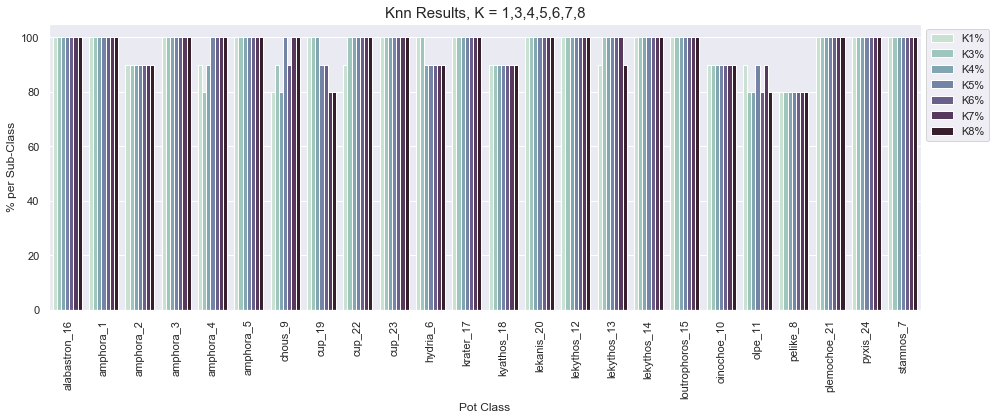

In [30]:
fig_dims = (14, 6)
fig, ax = plt.subplots(figsize=fig_dims)
sns.barplot(x="classes", y="vals", hue='cols', data=df2,palette = sns.cubehelix_palette(7, start=.95, rot=-.75)
           ,ax = ax)

ax.set(ylabel='% per Sub-Class')
ax.set_xticklabels(ax.get_xticklabels(),rotation=90)
ax.set(xlabel='Pot Class')
ax.set_title("Knn Results, K = 1,3,4,5,6,7,8",fontsize=15)
ax.legend(bbox_to_anchor=(1, 1))
plt.tight_layout()
#plt.savefig("Knn_results_test_data.png",pad_inches=0.0)


### Total Accuracy Bar Charts

In [31]:
total_prct = []
N = len(test_names)
prct = np.round((sum(df['K1'])/N)*100,1)
total_prct.append(prct)
prct = np.round((sum(df['K3'])/N)*100,1)
total_prct.append(prct)
prct = np.round((sum(df['K4'])/N)*100,1)
total_prct.append(prct)
prct = np.round((sum(df['K5'])/N)*100,1)
total_prct.append(prct)
prct = np.round((sum(df['K6'])/N)*100,1)
total_prct.append(prct)
prct = np.round((sum(df['K7'])/N)*100,1)
total_prct.append(prct)
prct = np.round((sum(df['K8'])/N)*100,1)
total_prct.append(prct)
neighbours = ["K1","K3","K4","K5","K6","K7","K8"]

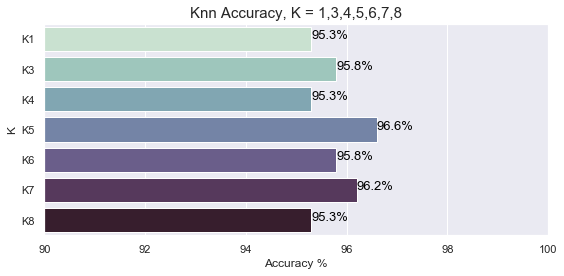

In [34]:
fig_dims = (8, 4)
fig, ax = plt.subplots(figsize=fig_dims)
g = sns.barplot(x=total_prct, y=neighbours,palette = sns.cubehelix_palette(len(neighbours), start=.95, rot=-.75),ax = ax)
for i in range(0,len(neighbours)):
    g.text(total_prct[i],i, str(total_prct[i])+"%", color='black', ha="left",fontsize=13)

ax.set(ylabel='K')
ax.set(xlabel='Accuracy %')
ax.set_title("Knn Accuracy, K = 1,3,4,5,6,7,8",fontsize=15)
ax.set(xlim=[90,100])
plt.tight_layout()
plt.show()
#fig.savefig("Knn_accuracy_test_data.png",bbox_inches = 'tight',pad_inches=0.0)
